# Project 1: Classification Analysis on Textual Data

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from matplotlib import mlab as mlab

In [2]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)
print(train_dataset.target_names)

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


## Question 1: Histogram

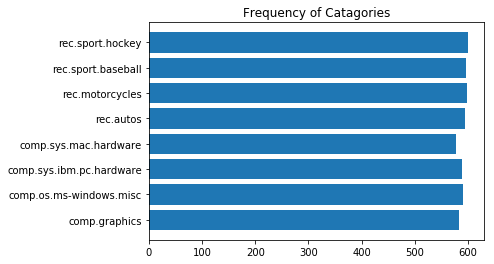

In [4]:
# count unique entries
dataset_name, dataset_count = np.unique(train_dataset.target, return_counts = True)

# plot histogram
plt.barh(np.arange(len(dataset_name)), dataset_count)
plt.title("Frequency of Catagories")
plt.rc('font',size = 14)
plt.yticks(np.arange(len(dataset_name)), np.array(categories)[dataset_name], rotation='horizontal')
plt.show()

## Question 2: Feature Extraction

In [5]:
# Defined stopwords
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords') #uncomm if 1st time run

stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))

from string import punctuation
print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
#print(combined_stopwords)

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32


In [6]:
# Lemmatize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
wnl = nltk.wordnet.WordNetLemmatizer()
#nltk.download('wordnet')#, if you need "corpora/wordnet", choose it
#nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
#nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word.isalpha() and word not in combined_stopwords)

In [8]:
# tfidf set min_df3, remove stop words, post_train_dataset = train_dataset after processer
count_vectorizer = CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english');
train_counts = count_vectorizer.fit_transform(train_dataset.data)
test_counts = count_vectorizer.transform(test_dataset.data)

In [9]:
print('Train Vectorizer Shape: ',train_counts.shape,'; Test Vectorizer Shape:',test_counts.shape)
#print(count_vectorizer.get_feature_names())

Train Vectorizer Shape:  (4732, 13837) ; Test Vectorizer Shape: (3150, 13837)


## Question 3: Dimensionality Reduction

In [10]:
# tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

train_tfidf = tfidf_transformer.fit_transform(train_counts)
test_tfidf = tfidf_transformer.transform(test_counts)
print(train_tfidf.shape,test_tfidf.shape)

(4732, 13837) (3150, 13837)


In [11]:
# training a classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

##### NMF

In [12]:
# NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, init='random', random_state= 42)
train_tfidf_nmf = nmf.fit_transform(train_tfidf)

print(train_tfidf_nmf.shape)

(4732, 50)


In [13]:
test_tfidf_nmf = nmf.transform(test_tfidf)

clf = MultinomialNB().fit(train_tfidf_nmf, train_dataset.target)

predicted = clf.predict(test_tfidf_nmf)

#for doc, category in zip(test_dataset.target, predicted):
    #print('%s => %s' % (test_dataset.target_names[doc], train_dataset.target_names[category]))

##### LSI

In [14]:
# Apply LSI
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=42)
train_tfidf_lsi = lsi.fit_transform(train_tfidf)

print(train_tfidf_lsi.shape)

(4732, 50)


In [15]:
from sklearn.svm import LinearSVC
test_tfidf_lsi = lsi.transform(test_tfidf)

clf = LinearSVC().fit(train_tfidf_lsi, train_dataset.target)

predicted = clf.predict(test_tfidf_lsi)

#for doc, category in zip(test_dataset.target, predicted):
    #print('%s => %s' % (test_dataset.target_names[doc], train_dataset.target_names[category]))

## Question 4: - Classification Algorithms

In [16]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [17]:
# convert dataset.target into binary, in which comp is 0 and rec is 1
# for issues of "multiclass format error"
bi_train_dataset_target = []
for num in train_dataset.target:
    if num < 4:
        bi_train_dataset_target.append(0)
    else:
        bi_train_dataset_target.append(1)

bi_test_dataset_target = []
for num in test_dataset.target:
    if num < 4:
        bi_test_dataset_target.append(0)
    else:
        bi_test_dataset_target.append(1)


In [18]:
# plot the graph
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()
    roc_auc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.legend(loc="lower right")
    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

In [19]:
# SVM
def SVM_fit_predict_and_evaluate_result(train_data, train_target, test_data, test_target, gamma):
    # SVM Classifier
    clf = SVC(C = gamma,gamma='auto')
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    predict_score = clf.decision_function(test_data)
    fpr, tpr, threshold = metrics.roc_curve(test_target, predict_score)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = 'binary')
    precision = metrics.precision_score(test_target, predict_target, average = 'binary')
    f1_score = metrics.f1_score(test_target, predict_target, average = 'binary')
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))
    
    # plot
    plot_roc(fpr, tpr)

##### LSI


LSI - hard margin SVM (gamma=1000)
Confusion matrix:
[[1506   54]
 [  34 1556]]
Accuracy: 0.9720634920634921
Recall: 0.9786163522012579
Precision: 0.9664596273291925
f1: 0.9724999999999999


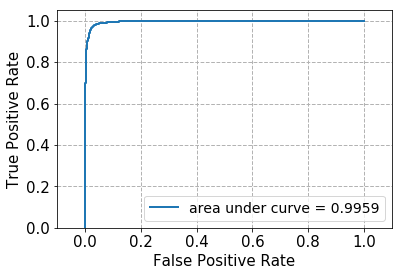

In [20]:
# LSI - Hard margin SVM
print("\nLSI - hard margin SVM (gamma=1000)")
SVM_fit_predict_and_evaluate_result(train_tfidf_lsi, bi_train_dataset_target, test_tfidf_lsi, bi_test_dataset_target, 1000)



LSI - hard margin SVM (gamma=0.0001)
Confusion matrix:
[[   0 1560]
 [   0 1590]]
Accuracy: 0.5047619047619047
Recall: 1.0
Precision: 0.5047619047619047
f1: 0.6708860759493671


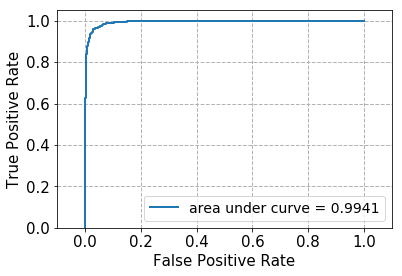

In [21]:
# LSI - Soft margin SVM
print("\nLSI - hard margin SVM (gamma=0.0001)")
SVM_fit_predict_and_evaluate_result(train_tfidf_lsi, bi_train_dataset_target, test_tfidf_lsi, bi_test_dataset_target, 0.0001)


##### NMF 


NMF - hard margin SVM (gamma=1000)
Confusion matrix:
[[1474   86]
 [  43 1547]]
Accuracy: 0.959047619047619
Recall: 0.9729559748427673
Precision: 0.9473361910593999
f1: 0.9599751784052126


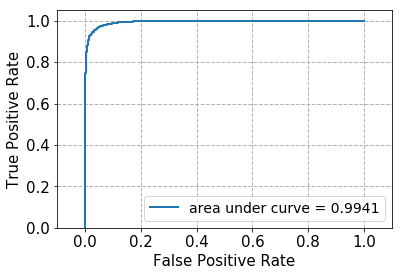

In [22]:
# NMF - Hard margin SVM
print("\nNMF - hard margin SVM (gamma=1000)")
SVM_fit_predict_and_evaluate_result(train_tfidf_nmf, bi_train_dataset_target, test_tfidf_nmf, bi_test_dataset_target, 1000)



NMF - hard margin SVM (gamma=0.0001)
Confusion matrix:
[[   0 1560]
 [   0 1590]]
Accuracy: 0.5047619047619047
Recall: 1.0
Precision: 0.5047619047619047
f1: 0.6708860759493671


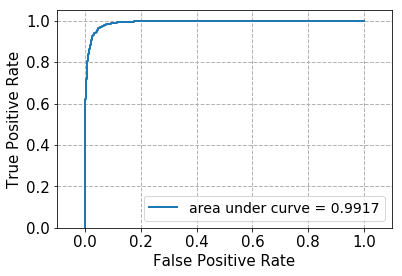

In [23]:
# NMF - Soft margin SVM
print("\nNMF - hard margin SVM (gamma=0.0001)")
SVM_fit_predict_and_evaluate_result(train_tfidf_nmf, bi_train_dataset_target, test_tfidf_nmf, bi_test_dataset_target, 0.0001)


### Question 4: Part 2: Cross-validation

In [24]:
from sklearn.model_selection import GridSearchCV
import math
def SVM_Best_predict_and_evaluate_result_regularization(train_data, train_target, test_data, test_target):
    
    parameters = {'C': [math.pow(10, k) for k in range(-3,4)]}
    clf = GridSearchCV(SVC(gamma='auto'), parameters, n_jobs=-1, cv=5)
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    predict_score = clf.decision_function(test_data)
    fpr, tpr, threshold = metrics.roc_curve(test_target, predict_score)
    values = [list(clf.cv_results_['param_C']), ["%.6f" % x for x in clf.cv_results_['mean_test_score']],list(clf.cv_results_['rank_test_score'])]
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = 'binary')
    precision = metrics.precision_score(test_target, predict_target, average = 'binary')
    f1_score = metrics.f1_score(test_target, predict_target, average = 'binary')    
    # draw table
    print('Parameters and Results:')
    print('C:',values[0])
    print('Test_Score:',values[1])
    print('Rank:',values[2])
    print("\nBest Parameters: \n{0}".format(clf.best_params_))
    print("\nConfusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))
    # plot
    plot_roc(fpr, tpr)

    


LSI
Parameters and Results:
C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
Test_Score: ['0.504861', '0.504861', '0.504861', '0.957312', '0.970414', '0.974852', '0.976331']
Rank: [5, 5, 5, 4, 3, 2, 1]

Best Parameters: 
{'C': 1000.0}

Confusion matrix:
[[1506   54]
 [  34 1556]]
Accuracy: 0.9720634920634921
Recall: 0.9786163522012579
Precision: 0.9664596273291925
f1: 0.9724999999999999


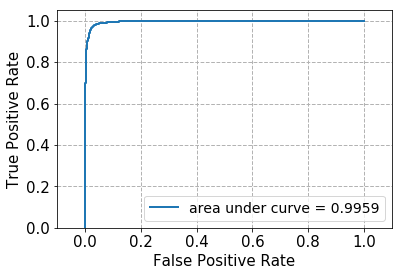

In [25]:
#SLI
print("\nLSI")
SVM_Best_predict_and_evaluate_result_regularization(train_tfidf_lsi, bi_train_dataset_target,test_tfidf_lsi,bi_test_dataset_target)



NMF
Parameters and Results:
C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
Test_Score: ['0.504861', '0.504861', '0.504861', '0.504861', '0.908073', '0.960482', '0.964708']
Rank: [4, 4, 4, 4, 3, 2, 1]

Best Parameters: 
{'C': 1000.0}

Confusion matrix:
[[1474   86]
 [  43 1547]]
Accuracy: 0.959047619047619
Recall: 0.9729559748427673
Precision: 0.9473361910593999
f1: 0.9599751784052126


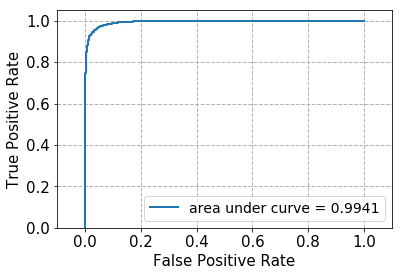

In [26]:
# NMF
print("\nNMF")
SVM_Best_predict_and_evaluate_result_regularization(train_tfidf_nmf, bi_train_dataset_target,test_tfidf_nmf,bi_test_dataset_target)


## Question 5: Logistoic Classifier

In [27]:
from sklearn.linear_model import LogisticRegression
def Logistic_fit_predict_and_evaluate_result(train_data, train_target, test_data, test_target):
    # Logistic
    clf = LogisticRegression(solver='liblinear')
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    predict_score = clf.predict_proba(test_data)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_target, predict_score)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = 'binary')
    precision = metrics.precision_score(test_target, predict_target, average = 'binary')
    f1_score = metrics.f1_score(test_target, predict_target, average = 'binary')
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))
    
    # plot
    plot_roc(fpr, tpr)

##### LSI 


LSI - Logistic without regularization
Confusion matrix:
[[1488   72]
 [  35 1555]]
Accuracy: 0.966031746031746
Recall: 0.9779874213836478
Precision: 0.9557467732022127
f1: 0.9667391980105688


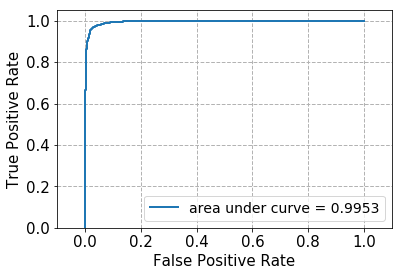

In [28]:
print("\nLSI - Logistic without regularization")
Logistic_fit_predict_and_evaluate_result(train_tfidf_lsi, bi_train_dataset_target, test_tfidf_lsi, bi_test_dataset_target)


##### NMF


NMF - Logistic without regularization
Confusion matrix:
[[1435  125]
 [  27 1563]]
Accuracy: 0.9517460317460318
Recall: 0.9830188679245283
Precision: 0.9259478672985783
f1: 0.9536302623550946


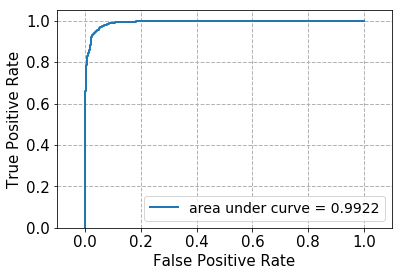

In [29]:
print("\nNMF - Logistic without regularization")
Logistic_fit_predict_and_evaluate_result(train_tfidf_nmf, bi_train_dataset_target, test_tfidf_nmf, bi_test_dataset_target)


### Question 5: Part 2: Regularization 

In [30]:
def Logistic_fit_predict_and_evaluate_result_regularization(train_data, train_target, test_data, test_target):
    
    parameters = {'penalty': ['l1', 'l2'], 'C': [math.pow(10, k) for k in range(-3,4)]}
    clf = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, n_jobs=-1, cv=5)
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    predict_score = clf.predict_proba(test_data)[:,1]
    values = [list(clf.cv_results_[r'param_penalty']), list(clf.cv_results_[r'param_C']), ["%.6f" % x for x in clf.cv_results_[r'mean_test_score']],list(clf.cv_results_[r'rank_test_score'])]
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = 'binary')
    precision = metrics.precision_score(test_target, predict_target, average = 'binary')
    f1_score = metrics.f1_score(test_target, predict_target, average = 'binary')    
    # draw table
    print('Parameters and Results:')
    print('Penalty:',values[0])
    print('C:',values[1])
    print('Test_Score:',values[2])
    print('Rank:',values[3])
    print("\nBest Parameters: \n{0}".format(clf.best_params_))
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))

##### LSI 

In [31]:
print("\nLSI - Logistic with Regularization")
Logistic_fit_predict_and_evaluate_result_regularization(train_tfidf_lsi, bi_train_dataset_target, test_tfidf_lsi, bi_test_dataset_target)



LSI - Logistic with Regularization
Parameters and Results:
Penalty: ['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2']
C: [0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0, 100.0, 100.0, 1000.0, 1000.0]
Test_Score: ['0.495139', '0.694844', '0.893491', '0.946957', '0.961538', '0.968724', '0.969992', '0.971893', '0.976120', '0.976120', '0.974852', '0.976754', '0.974641', '0.975063']
Rank: [14, 13, 12, 11, 10, 9, 8, 7, 2, 2, 5, 1, 6, 4]

Best Parameters: 
{'C': 100.0, 'penalty': 'l2'}
Accuracy: 0.9726984126984127
Recall: 0.979874213836478
Precision: 0.966501240694789
f1: 0.9731417863835102


##### NMF

In [32]:
print("\nNMF - Logistic with Regularization")
Logistic_fit_predict_and_evaluate_result_regularization(train_tfidf_nmf, bi_train_dataset_target, test_tfidf_nmf, bi_test_dataset_target)



NMF - Logistic with Regularization
Parameters and Results:
Penalty: ['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2']
C: [0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0, 100.0, 100.0, 1000.0, 1000.0]
Test_Score: ['0.495139', '0.504861', '0.495139', '0.514159', '0.714708', '0.908284', '0.955199', '0.954776', '0.967878', '0.963018', '0.968301', '0.965554', '0.968301', '0.967033']
Rank: [13, 12, 13, 11, 10, 9, 7, 8, 3, 6, 1, 5, 1, 4]

Best Parameters: 
{'C': 100.0, 'penalty': 'l1'}
Accuracy: 0.9606349206349206
Recall: 0.9685534591194969
Precision: 0.9541511771995044
f1: 0.9612983770287141


## Question 6: Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB
def NB_gaussian_fit_predict_and_evaluate_result(train_data, train_target, test_data, test_target):
    # Naive Bayes
    clf = GaussianNB()
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    predict_score = clf.predict_proba(test_data)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_target, predict_score)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = 'binary')
    precision = metrics.precision_score(test_target, predict_target, average = 'binary')
    f1_score = metrics.f1_score(test_target, predict_target, average = 'binary')
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))
    
    # plot
    plot_roc(fpr, tpr)

##### LSI


LSI - NBGaussian
Confusion matrix:
[[1235  325]
 [  43 1547]]
Accuracy: 0.8831746031746032
Recall: 0.9729559748427673
Precision: 0.8263888888888888
f1: 0.8937030618139804


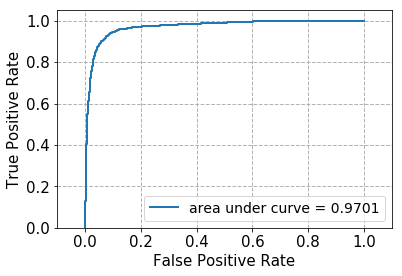

In [34]:
print("\nLSI - NBGaussian")
NB_gaussian_fit_predict_and_evaluate_result(train_tfidf_lsi, bi_train_dataset_target, test_tfidf_lsi, bi_test_dataset_target)


##### NMF


NMF - NBGaussian
Confusion matrix:
[[1461   99]
 [  82 1508]]
Accuracy: 0.9425396825396826
Recall: 0.9484276729559749
Precision: 0.9383945239576851
f1: 0.9433844228964653


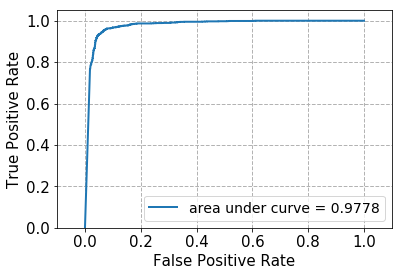

In [35]:
print("\nNMF - NBGaussian")
NB_gaussian_fit_predict_and_evaluate_result(train_tfidf_nmf, bi_train_dataset_target, test_tfidf_nmf, bi_test_dataset_target)


## Question 7: Grid Search of Parameters

In [36]:
# w/ header SVC
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [LinearSVC(C=100, random_state=42)]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, bi_train_dataset_target)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])


C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['0.967456', '0.965554', '0.968301', '0.966822', '0.975063', '0.974641', '0.975486', '0.976754']


C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [37]:
# w/ header GNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, bi_train_dataset_target)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])



C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['0.939138', '0.941251', '0.942308', '0.942519', '0.909763', '0.906382', '0.906382', '0.900042']


In [38]:
# w/ header logR
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [LogisticRegression(C=100, solver='liblinear')],
        'clf__penalty': ['l1','l2']
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, bi_train_dataset_target)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])


['0.967667', '0.967456', '0.968090', '0.970203', '0.975063', '0.973795', '0.975486', '0.975275', '0.959214', '0.963018', '0.963863', '0.964074', '0.974641', '0.973795', '0.974218', '0.975697']


In [39]:
# w/o header
categories7 = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset7 = fetch_20newsgroups(subset = 'train', remove=('headers','footers'),categories = categories, shuffle = True, random_state = None)

# convert dataset.target into binary, in which comp is 0 and rec is 1
# for issues of "multiclass format error"
bi_train_dataset_target7 = []
for num in train_dataset7.target:
    if num < 4:
        bi_train_dataset_target7.append(0)
    else:
        bi_train_dataset_target7.append(1)


In [40]:
# w/o header GNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset7.data, bi_train_dataset_target7)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])



['0.949070', '0.949281', '0.936602', '0.938081', '0.850803', '0.854818', '0.834531', '0.845520']


In [41]:
# w/o header SVC
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [LinearSVC(C=100, random_state=42)]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset7.data, bi_train_dataset_target7)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])


['0.965554', '0.965342', '0.960482', '0.960059', '0.972105', '0.972105', '0.966399', '0.966822']


C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
# w/ header logR
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
])

param_grid = [
    {
        'vect': [CountVectorizer(min_df=3, stop_words='english'), CountVectorizer(min_df=5, stop_words='english'), CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english'), CountVectorizer(min_df = 5, analyzer = stem_rmv_punc, stop_words = 'english')],
        'reduce_dim': [NMF(),TruncatedSVD()],
        'reduce_dim__n_components': [50],
        'clf': [LogisticRegression(C=100, solver='liblinear')],
        'clf__penalty': ['l1','l2']
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset7.data, bi_train_dataset_target7)

print(["%.6f" % x for x in grid.cv_results_[r'mean_test_score']])


['0.965554', '0.966188', '0.960693', '0.962806', '0.971893', '0.971893', '0.968090', '0.968512', '0.959214', '0.959848', '0.956467', '0.956044', '0.972105', '0.972950', '0.966822', '0.967033']


## Question 8: Multiclass Classification

In [43]:
categories8 = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'misc.forsale', 'soc.religion.christian']
train_dataset8 = fetch_20newsgroups(subset = 'train', categories = categories8, shuffle = True, random_state = None)
test_dataset8 = fetch_20newsgroups(subset = 'test', categories = categories8, shuffle = True, random_state = None)
print(train_dataset8.target_names)


['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']


In [44]:
count_vectorizer8 = CountVectorizer(min_df = 3, analyzer = stem_rmv_punc, stop_words = 'english');
train_counts8 = count_vectorizer.fit_transform(train_dataset8.data)
test_counts8 = count_vectorizer.transform(test_dataset8.data)

train_tfidf8 = tfidf_transformer.fit_transform(train_counts8)
test_tfidf8 = tfidf_transformer.transform(test_counts8)

train_tfidf_nmf8 = nmf.fit_transform(train_tfidf8)
test_tfidf_nmf8 = nmf.transform(test_tfidf8)

train_tfidf_lsi8 = lsi.fit_transform(train_tfidf8)
test_tfidf_lsi8 = lsi.transform(test_tfidf8)

In [45]:
# NB_gaussian
def NB_gaussian_fit_predict_and_evaluate_result8(train_data, train_target, test_data, test_target):
    # Naive Bayes
    clf = GaussianNB()
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = None)
    precision = metrics.precision_score(test_target, predict_target, average = None)
    f1_score = metrics.f1_score(test_target, predict_target, average = None)
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))

In [46]:
NB_gaussian_fit_predict_and_evaluate_result8(train_tfidf_lsi8, train_dataset8.target, test_tfidf_lsi8, test_dataset8.target)

Confusion matrix:
[[218  45 124   5]
 [101 148 132   4]
 [ 44  41 301   4]
 [  0   1  14 383]]
Accuracy: 0.670926517571885
Recall: [0.55612245 0.38441558 0.77179487 0.96231156]
Precision: [0.60055096 0.62978723 0.52714536 0.96717172]
f1: [0.57748344 0.47741935 0.6264308  0.96473552]


In [47]:
NB_gaussian_fit_predict_and_evaluate_result8(train_tfidf_nmf8, train_dataset8.target, test_tfidf_nmf8, test_dataset8.target)

Confusion matrix:
[[299  31  57   5]
 [ 85 224  74   2]
 [ 63  36 279  12]
 [  4   0   4 390]]
Accuracy: 0.7616613418530351
Recall: [0.7627551  0.58181818 0.71538462 0.9798995 ]
Precision: [0.66297118 0.76975945 0.67391304 0.95354523]
f1: [0.70937129 0.66272189 0.69402985 0.96654275]


In [48]:
# One-to-one
from sklearn.multiclass import OneVsOneClassifier
def SVC_ovo_fit_predict_and_evaluate_result8(train_data, train_target, test_data, test_target):
    
    clf = OneVsOneClassifier(LinearSVC(C=10, random_state=42))
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = None)
    precision = metrics.precision_score(test_target, predict_target, average = None)
    f1_score = metrics.f1_score(test_target, predict_target, average = None)
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))

In [49]:
SVC_ovo_fit_predict_and_evaluate_result8(train_tfidf_lsi8, train_dataset8.target, test_tfidf_lsi8, test_dataset8.target)

Confusion matrix:
[[319  51  22   0]
 [ 41 322  22   0]
 [ 20  25 342   3]
 [  2   3   0 393]]
Accuracy: 0.8792332268370607
Recall: [0.81377551 0.83636364 0.87692308 0.98743719]
Precision: [0.83507853 0.80299252 0.88601036 0.99242424]
f1: [0.82428941 0.81933842 0.8814433  0.98992443]


In [50]:
SVC_ovo_fit_predict_and_evaluate_result8(train_tfidf_nmf8, train_dataset8.target, test_tfidf_nmf8, test_dataset8.target)

Confusion matrix:
[[325  42  25   0]
 [ 73 282  28   2]
 [ 46  17 325   2]
 [  5   2   8 383]]
Accuracy: 0.8402555910543131
Recall: [0.82908163 0.73246753 0.83333333 0.96231156]
Precision: [0.72383073 0.82215743 0.84196891 0.98966408]
f1: [0.77288942 0.77472527 0.83762887 0.97579618]


In [51]:
# One-to-Rest
from sklearn.multiclass import OneVsRestClassifier
def SVC_ovr_fit_predict_and_evaluate_result8(train_data, train_target, test_data, test_target):
    
    clf = OneVsRestClassifier(LinearSVC(C=100, random_state=42))
    clf.fit(train_data, train_target)
    predict_target = clf.predict(test_data)
    
    # return confusion_matrix, accuracy, recall, recision, f1
    confu_mx = metrics.confusion_matrix(test_target, predict_target)
    accuracy = metrics.accuracy_score(test_target, predict_target)
    recall = metrics.recall_score(test_target, predict_target, average = None)
    precision = metrics.precision_score(test_target, predict_target, average = None)
    f1_score = metrics.f1_score(test_target, predict_target, average = None)
    print("Confusion matrix:")
    print(confu_mx)
    print("Accuracy: {}\nRecall: {}\nPrecision: {}\nf1: {}".format(accuracy, recall, precision, f1_score))

In [52]:
SVC_ovr_fit_predict_and_evaluate_result8(train_tfidf_lsi8, train_dataset8.target, test_tfidf_lsi8, test_dataset8.target)

C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion matrix:
[[309  57  25   1]
 [ 36 324  25   0]
 [ 19  20 347   4]
 [  4   1   2 391]]
Accuracy: 0.876038338658147
Recall: [0.78826531 0.84155844 0.88974359 0.98241206]
Precision: [0.83967391 0.80597015 0.86967419 0.98737374]
f1: [0.81315789 0.82337992 0.87959442 0.98488665]


C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [53]:
SVC_ovr_fit_predict_and_evaluate_result8(train_tfidf_nmf8, train_dataset8.target, test_tfidf_nmf8, test_dataset8.target)

C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion matrix:
[[317  48  25   2]
 [ 59 292  29   5]
 [ 31  19 336   4]
 [  4   1   2 391]]
Accuracy: 0.8536741214057508
Recall: [0.80867347 0.75844156 0.86153846 0.98241206]
Precision: [0.77128954 0.81111111 0.85714286 0.97263682]
f1: [0.78953923 0.78389262 0.85933504 0.9775    ]


C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\xxc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
